## Start with Olivetti dataset

### Olivetti Face 

The original database is available from  
http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

There are 10 different images for each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open/closed eyes, smiling/not smiling) and facial
details (glasses/no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

### A preview image of the Database of Faces：

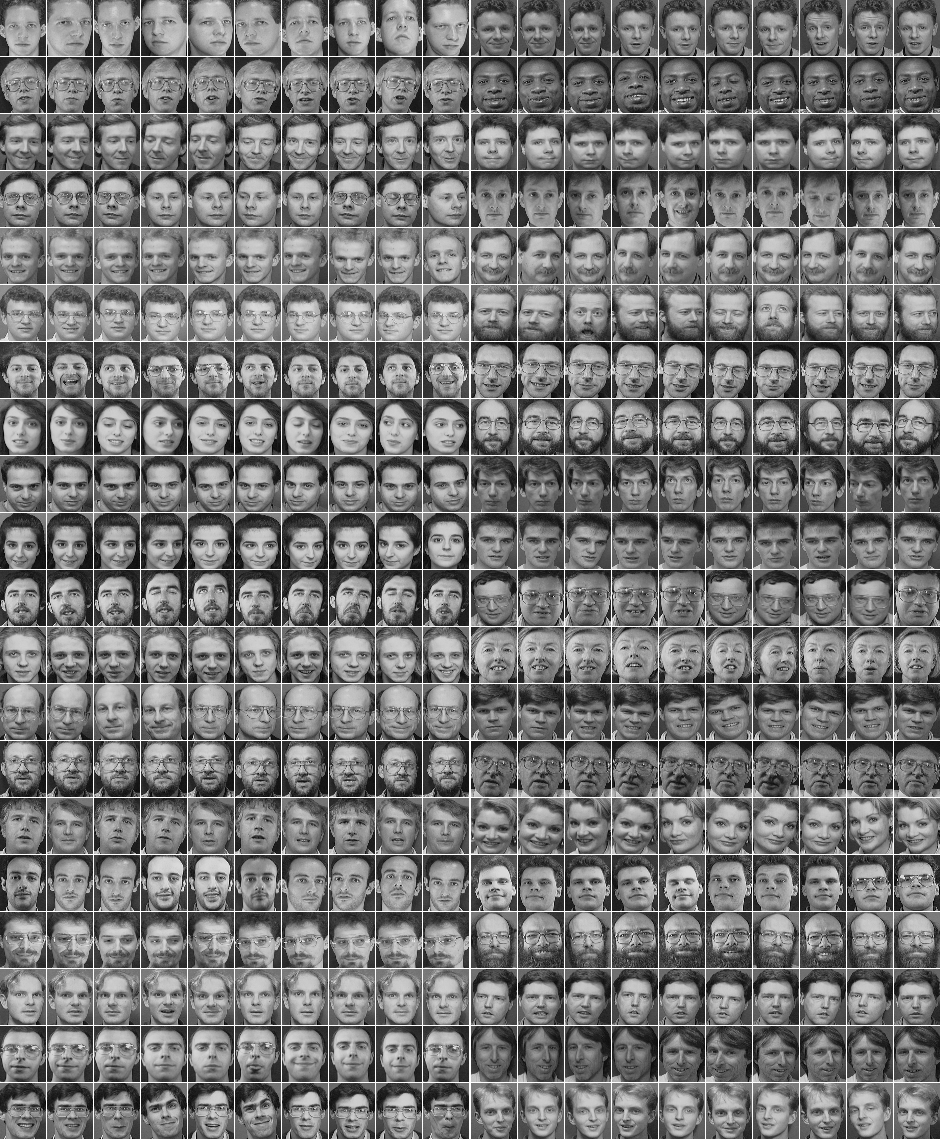

In [1]:
from IPython.display import Image
Image('olivettifaces.png') 

### Fetch the data

In [2]:
from sklearn.datasets import fetch_olivetti_faces
olive_people = fetch_olivetti_faces(shuffle=True, random_state=42, download_if_missing=True)

In [119]:
X_images = olive_people.images
X_data   = olive_people.data
y = olive_people.target

### Train a Benchmark Model Using SVM

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

Train on 300 faces, valid on 50, test on 50

In [102]:
from sklearn.model_selection import train_test_split
X_train_, X_test, y_train_, y_test = train_test_split(X_data, y, test_size=50./400, random_state=8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=50./350, random_state=8)
print X_train.shape, y_train.shape
print X_valid.shape, y_valid.shape
print X_test.shape, y_test.shape

(300, 4096) (300,)
(50, 4096) (50,)
(50, 4096) (50,)


In [103]:
n_components = 150
h = X_images.shape[1]
w = X_images.shape[2]
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))

In [104]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

The most significative eigenfaces

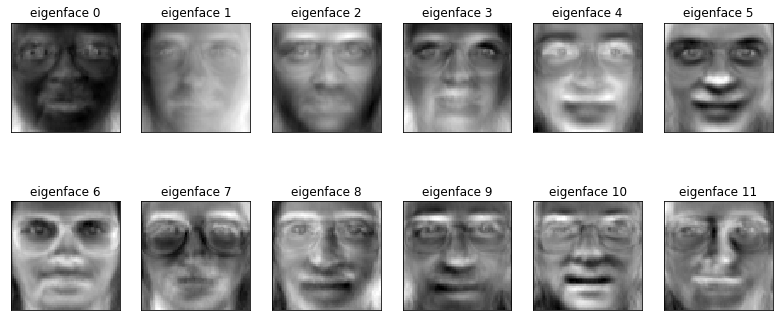

In [105]:
%matplotlib inline 
from matplotlib import pyplot as plt
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [106]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

In [107]:
y_pred = clf.predict(X_test_pca)

In [108]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print "Accuracy: ", accuracy_score(y_test, y_pred)*100,'%'
print "Precision: ", precision_score(y_test, y_pred, average='micro')*100,'%'  
print "Recall: ", recall_score(y_test, y_pred, average='micro')*100 ,'%' 

Accuracy:  96.0 %
Precision:  96.0 %
Recall:  96.0 %


### Build a Toy CNN Model

Preprocessing the data for Keras input 

In [122]:
from keras.utils import np_utils
X = X_images.reshape(-1, X.shape[1], X.shape[2], 1)
y = np_utils.to_categorical(y, 40)

Split the dataset the same as the benchmark model

In [123]:
from sklearn.model_selection import train_test_split
X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=50./400, random_state=8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=50./350, random_state=8)
print X_train.shape, y_train.shape
print X_valid.shape, y_valid.shape
print X_test.shape, y_test.shape

(300, 64, 64, 1) (300, 40)
(50, 64, 64, 1) (50, 40)
(50, 64, 64, 1) (50, 40)


In [124]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, LocallyConnected2D
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam

In [173]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(64, 64, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(32, 3, 3, border_mode= 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(40, activation='softmax'))

In [187]:
#epochs = 40
lrate = 0.00005
#decay = lrate/epochs
adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size= 20, nb_epoch= 10, verbose=2, validation_data=(X_valid, y_valid))

Train on 300 samples, validate on 50 samples
Epoch 1/10
3s - loss: 0.0933 - acc: 0.9700 - val_loss: 0.1270 - val_acc: 0.9800
Epoch 2/10
3s - loss: 0.0716 - acc: 0.9800 - val_loss: 0.1260 - val_acc: 0.9800
Epoch 3/10
3s - loss: 0.0790 - acc: 0.9700 - val_loss: 0.1336 - val_acc: 0.9600
Epoch 4/10
3s - loss: 0.0943 - acc: 0.9667 - val_loss: 0.1490 - val_acc: 0.9400
Epoch 5/10
3s - loss: 0.0852 - acc: 0.9767 - val_loss: 0.1263 - val_acc: 0.9600
Epoch 6/10
3s - loss: 0.1064 - acc: 0.9433 - val_loss: 0.1244 - val_acc: 0.9800
Epoch 7/10
4s - loss: 0.0679 - acc: 0.9800 - val_loss: 0.1297 - val_acc: 0.9600
Epoch 8/10
3s - loss: 0.1043 - acc: 0.9667 - val_loss: 0.1334 - val_acc: 0.9600
Epoch 9/10
3s - loss: 0.1307 - acc: 0.9533 - val_loss: 0.1314 - val_acc: 0.9600
Epoch 10/10
3s - loss: 0.0950 - acc: 0.9833 - val_loss: 0.1252 - val_acc: 0.9600


In [188]:
y_pred = model.predict(X_test)

In [189]:
print "Accuracy: ", accuracy_score(y_pred.argmax(1), y_test.argmax(1))*100,'%'
print "Precision: ", precision_score(y_pred.argmax(1), y_test.argmax(1), average='micro')*100,'%'  
print "Recall: ", recall_score(y_pred.argmax(1), y_test.argmax(1), average='micro')*100 ,'%'

Accuracy:  98.0 %
Precision:  98.0 %
Recall:  98.0 %


In [190]:
model.save('model_1_0308.h5')